The challenge that this notebook is going to tackle is one of natural language processing. The goal of this notebook is to develop a machine learning model that will allow for a tweet with associated metadata be binarily classified as being about a fake or real disaster. The solution outputted by this notebook will be a binary value to indicate it an associated tweet is about a real disaster. 

The data that will be used in this assignment is a series of 7,613 tweets with some optional metadata. The data has been provided by the Kaggle challenge (https://www.kaggle.com/c/nlp-getting-started/data) that is being submitted to, for evaluation. The features that are provided are the actual tweet of max length 157, key word, and location.

Of the 7,613 tweets, 61 lacked a key word, and 2,533 lacked a location. 4,342 were not real disasters and 3,271 were. Of real disasters had a higher proportion of key words which could be a useful statistic for training the model. 

As part of EDA, I outputted charts of the cunts of the null vales and the count of values. There are 1,071 more tweets that are about non-disasters. This discrepancy could become an issue as the models are trained but can be countered by balancing the classes with duplicate data or trimming the non-disaster tweets. Of note is that the maximum tweet is 157 characters long and future utilization of resultant models will be dealing with longer tweets as character lengths have increased.

The model that was first created was a transfer learning model that utilized the distil_bert_base_en_uncased model from the Keras library the reason for choosing a neural net for this notebook over the methods that were used in previous courses for categorizing news data is that this method allows for the leveraging of existing models. This model achieved an 81% accuracy score on the challenge. Once this baseline model was established, I modified the model to try out different dropout rate, existing preprocessors and existing classifiers. The results of the different models are at the end of the notebook where the accuracy and losses are charted. The models that tested with include various variations on Bert, RoBERTa and DistilBERT.

The modification on the model resulted in a final accuracy score of 84% ways to further improve this might be to develop an ensemble model that combines additional pretrained NLP models or gather additional tweet data to train on. 
rain on. 


In [1]:
import pandas as pd 
df_train = pd.read_csv("./data/nlp-getting-started/train.csv")
df_test = pd.read_csv("./data/nlp-getting-started/test.csv")
print(df_train.shape)
label_counts = df_train['target'].value_counts()
print(label_counts)
print(df_train.describe())
print(df_train.dtypes)
print(df_train.isnull())
print(df_train.isnull().sum())
print(df_train.head())

(7613, 5)
target
0    4342
1    3271
Name: count, dtype: int64
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object
         id  keyword  location   text  target
0     False     True      True  False   False
1     False     True      True  False   False
2     False     True      True  False   False
3     False     True      True  False   False
4     False     True      True  False   False
...     ...      ...       ...    ...     ...
7608  False     True      True  False   False
7609  False     True      True  False   False
7610  False     True      True  False   False
7611  False     True      True  False   False
7612  False     True      True  Fa

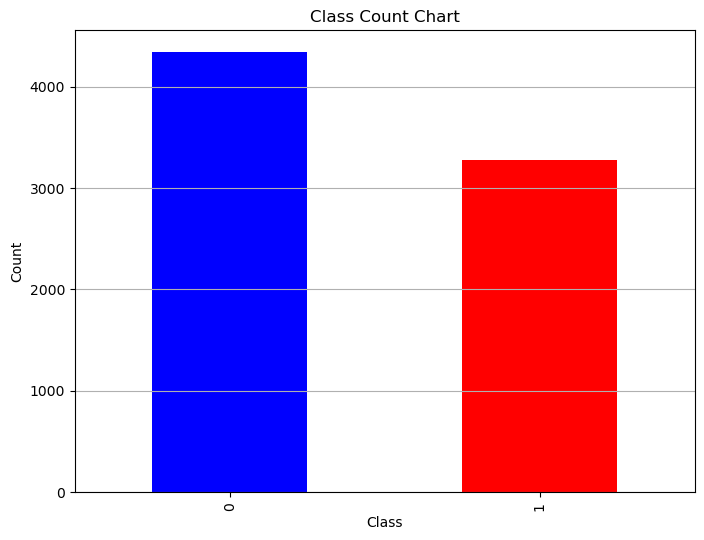

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red']) 
plt.title('Class Count Chart')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='-')
plt.show()

In [3]:
print("Null Metrics")
print(df_train[df_train['target'] == 1].isnull().sum())
print(df_train[df_train['target'] == 0].isnull().sum())

Null Metrics
id             0
keyword       42
location    1075
text           0
target         0
dtype: int64
id             0
keyword       19
location    1458
text           0
target         0
dtype: int64


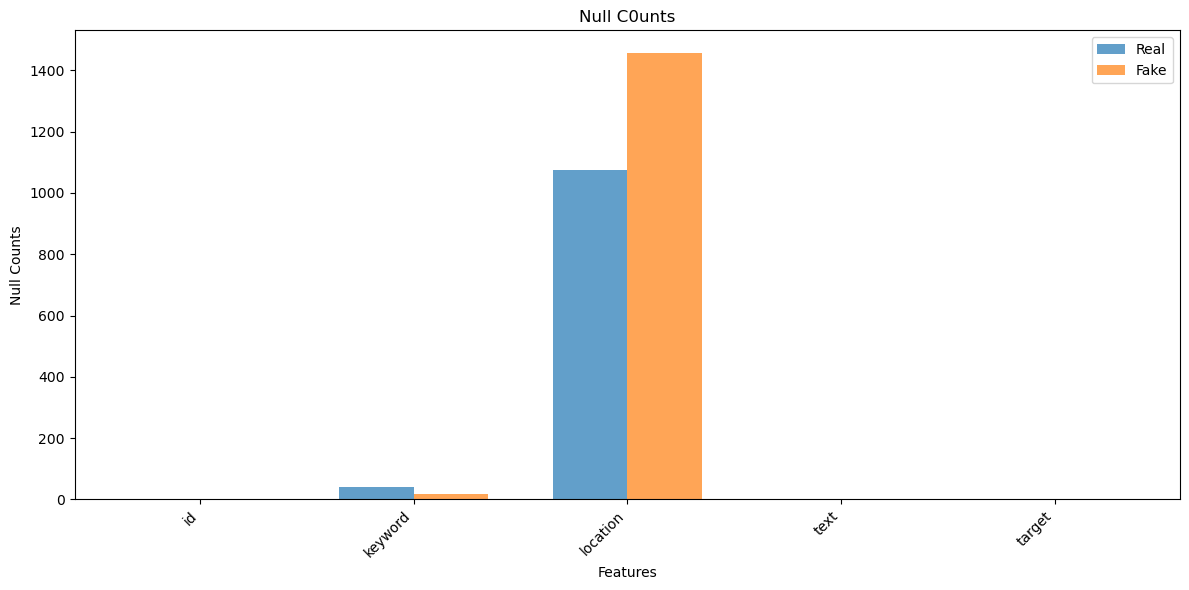

In [5]:
import matplotlib.pyplot as plt
import numpy as np

null_counts_real = df_train[df_train['target'] == 1].isnull().sum()
null_counts_fake = df_train[df_train['target'] == 0].isnull().sum()

feature_names = null_counts_real.index
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(feature_names))

ax.bar(x - bar_width/2, null_counts_real.values, bar_width, label='Real', alpha=0.7)
ax.bar(x + bar_width/2, null_counts_fake.values, bar_width, label='Fake', alpha=0.7)

# Customize the plot
ax.set_xlabel('Features')
ax.set_ylabel('Null Counts')
ax.set_title('Null C0unts')
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
print("Tweet Length")
print(df_train["length"].describe())

Tweet Length
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


In [ ]:
import os
import tensorflow as tf
import keras
os.environ['KERAS_BACKEND'] = 'tensorflow'
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 40
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [ ]:
import keras_nlp

preset= "roberta_large_en"
preprocessor = keras_nlp.models.RobertaPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor"
                                                                  )

# Pretrained classifier.Preprocessor
classifier = keras_nlp.models.RobertaClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2,dropout=0.3)
classifier.summary()


In [ ]:
try:
    os.mkdir("../tmp")
except:
    print("Directory /tmp already exists")

checkpoint = tf.keras.callbacks.ModelCheckpoint("../tmp/multi_class_weights_1.weights.h5", 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=False,
                                                save_weights_only=True)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        self.patience = 3
        self.best = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if np.greater(logs["val_accuracy"], self.best):
            self.wait = 0
            self.best = logs["val_accuracy"]
        else:
            self.wait +=1
            if self.wait >= self.patience:
                print(f"Stopping Training. Validation accuracy hasn't improved >= {self.patience} times")
                self.model.stop_training=True
                

In [ ]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val),
                         callbacks=[checkpoint, EarlyStoppingCallback()]
                        )

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

y_pred_train = classifier.predict(X_train)
displayConfusionMatrix(y_train, y_pred_train, "Training")

y_pred_val = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [ ]:
sample_submission = pd.read_csv("./data/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)
sample_submission.to_csv("submission.csv", index=False)

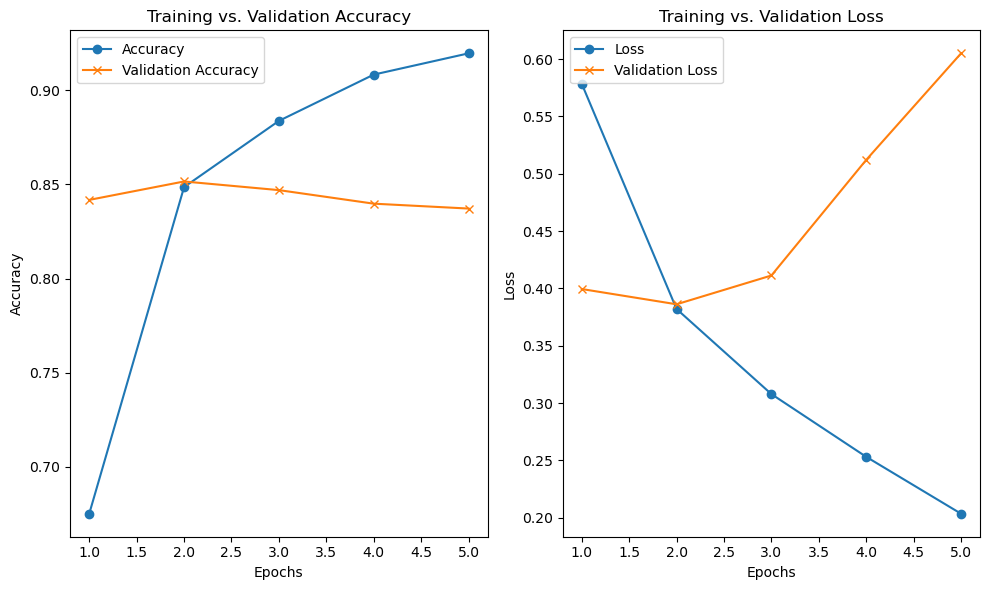

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
#roberta_large_en
df = pd.read_csv("./e_history_8.csv")

epochs = df['Epoch'] 
accuracy = df['accuracy']
loss = df['loss']
val_accuracy = df['val_accuracy']
val_loss = df['val_loss']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

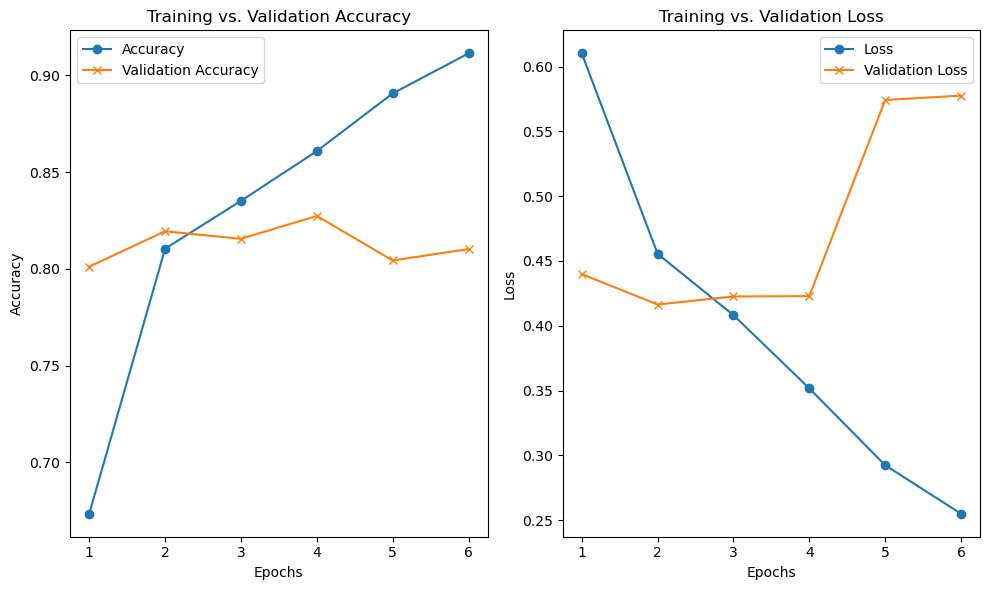

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#bert_large_en
df = pd.read_csv("./e_history_9.csv")

epochs = df['Epoch'] 
accuracy = df['accuracy']
loss = df['loss']
val_accuracy = df['val_accuracy']
val_loss = df['val_loss']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

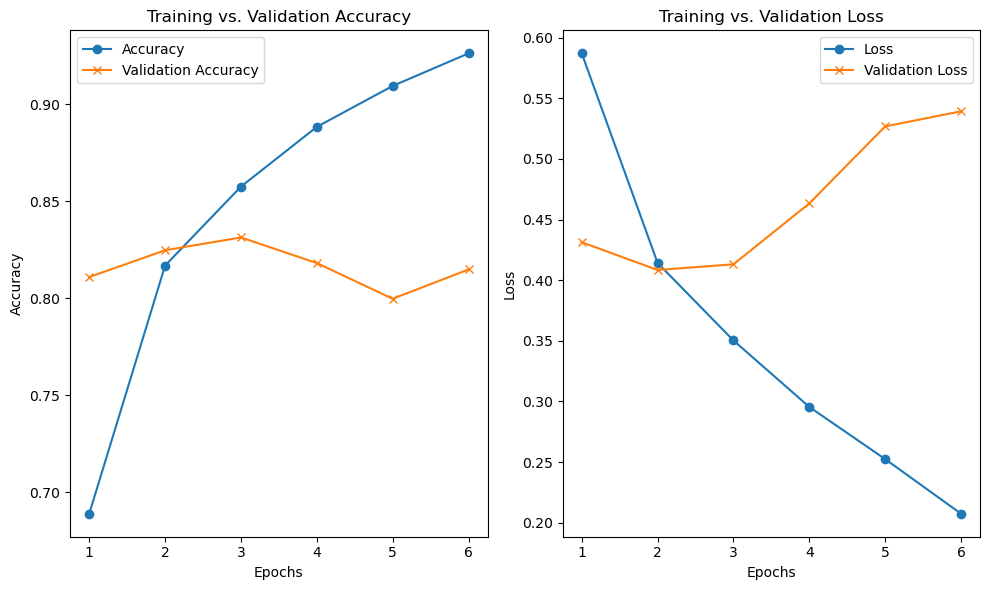

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
#distil_bert_base_multi
df = pd.read_csv("./e_history_10.csv")

epochs = df['Epoch'] 
accuracy = df['accuracy']
loss = df['loss']
val_accuracy = df['val_accuracy']
val_loss = df['val_loss']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

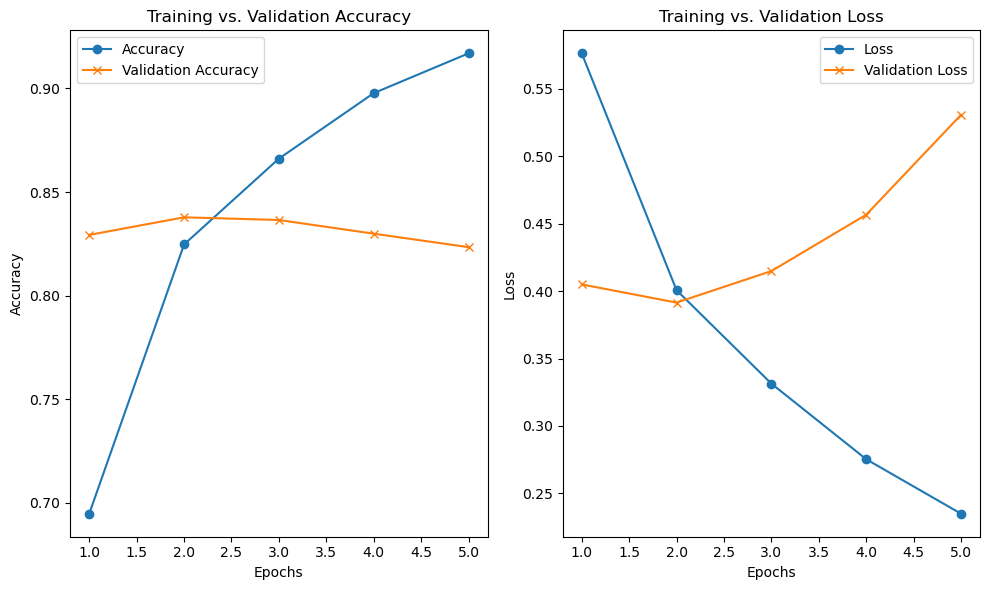

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
#distil_bert_base_en
df = pd.read_csv("./e_history_11.csv")

epochs = df['Epoch'] 
accuracy = df['accuracy']
loss = df['loss']
val_accuracy = df['val_accuracy']
val_loss = df['val_loss']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

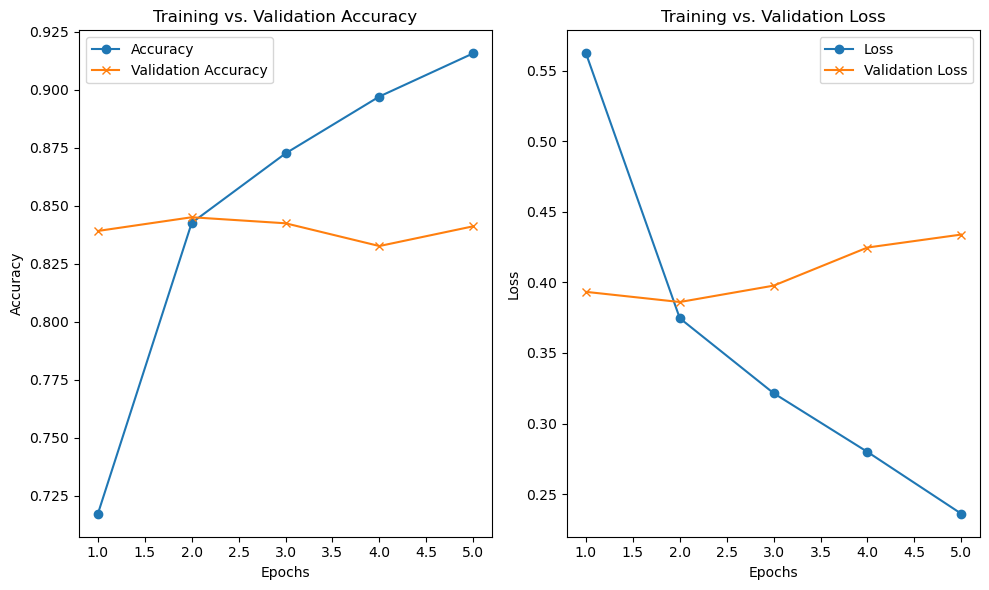

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
#distil_bert_base_en_uncased
df = pd.read_csv("./e_history_12.csv")

epochs = df['Epoch'] 
accuracy = df['accuracy']
loss = df['loss']
val_accuracy = df['val_accuracy']
val_loss = df['val_loss']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Code References:
https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook
https://keras.io/api/keras_nlp/models/
